In [1]:
import numpy as np

# Comparando implementações do Naive Bayes para dados numéricos

Nessa parte da prática analisaremos um pouco mais a fundo como podemos lidar com dados numéricos (contínuos) utilizando o NB.

Diferentemente de atributos discretos, nós normalmente não falamos de `P(x=valor)` porque, em dados contínuos, estritamente o resultado é 0 para qualquer valor específico! Existem infinitos valores contínuos entre qualquer intervalo real :D

É mais comum falamos em funções de probabilidade cumulativa (e.g., `P(x < valor)`, `P(x > valor)` ou `P(valor1 < x < valor2)`) ou funções de densidade de probabilidade (PDF -- não vou usar a sigla em português :P). Utilizamos o último caso na nossa implementação do GaussianNB:

Nós **assumimos** que nossos dados seguiam distribuições gaussianas e utilizamos as (lindas) propriedades desse tipo de distribuição em nosso favor.

No entanto, apesar de parecer algo razoável (e aplicações práticas demonstram isso), colocamos um "baita" de um viés no nosso modelo preditivo.

Aqui, exploraremos uma outra alternativa (que infelizmente não está disponível no `sklearn` diretamente).

## Vamos revisitar a nossa implementação de GaussianNaiveBayes e "apertar uns parafusos"

In [14]:
# Faremos nossa classe compativel com todas as ferramentas do sklearn, por exemplo: cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin


class GaussianNaiveBayes(BaseEstimator, ClassifierMixin):
    def __init__(self):
        super().__init__()
    
    def fit(self, X, y):
        # Seleciona as classes do problema
        self.classes = np.sort(np.unique(y))
        
        self.logprior = {}
        self.likelihood = {}
        for c in self.classes:
            self.likelihood[c] = {}

            class_mask = y == c
            
            self.logprior[c] = np.log(len(y[class_mask]) / len(y))
            
            Mu = np.mean(X[class_mask], axis=0)
            Var = np.var(X[class_mask], axis=0)
            
            # Para cada atributo preditivo
            for j in range(X.shape[1]):
                # Guardamos uma função gaussiana do likelihood
                self.likelihood[c][j] = (lambda x, mu=Mu[j], var=Var[j] : 
                                         (1 / np.sqrt(2 * np.pi * var)) * np.exp(- ((x - mu) ** 2) / (2 * var)))
                
    def predict(self, X):
        return self.classes[np.argmax(self.predict_proba(X), axis=1)]
        
    
    def predict_proba(self, X):
        # Numero de amostras x numero de classes
        proba = np.zeros((len(X), len(self.classes)))
        
        for c in self.classes:
            # Adicionamos a probabilidade a priori (estamos utilizando a propriedade aditiva dos logs)
            proba[:, c] += self.logprior[c]
            for j in range(X.shape[1]):
                # Usaremos log likelihood como na aula
                proba[:, c] += np.log(self.likelihood[c][j](X[:, j]))
        
        # Aplicamos a funçao exponencial para desfazer o efeito do log
        proba = np.exp(proba)
        
        # Softmax function para obtermos uma distribuição de probabilidade
        exp_proba = np.exp(proba)
        proba = exp_proba / np.sum(exp_proba, axis=1)[:, None]

        return proba

## Exploraremos ainda uma outra possibilidade: KDE

Até o momento fizemos algumas suposições sobre os nossos dados:

- Os dados são binários: Bernoulli Naive Bayes
- Os dados são categóricos: Categorical Naive Bayes
- Os dados são contagens (histogramas): Multinomial Naive Bayes
- **Os dados são contínuos: Gaussian Naive Bayes**

Mas e se os nossos atributos preditivos (features) não seguem uma distribuição normal?

### Vamos gerar alguns dados sintéticos para ilustrar esse problema

In [3]:
from sklearn.datasets import make_classification 

X, y = make_classification(n_samples=200, n_features=4, random_state=1,
                           n_clusters_per_class=3, n_informative=4, n_redundant=0,
                           n_repeated=0)

### Vamos visualizar a distribuição dos dados

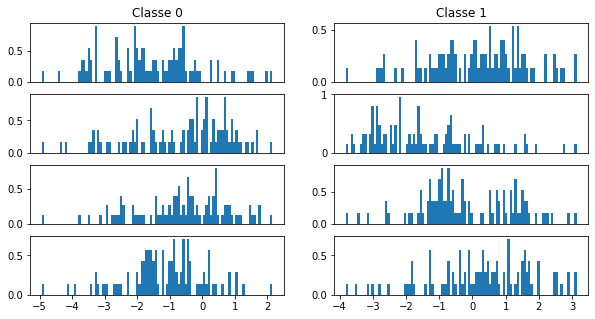

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5), nrows=4, ncols=2)

for c in range(2):
    mask = y == c
    for i in range(X.shape[1]):
        X_filt = X[mask, i]
        ax[i][c].hist(X_filt, bins=100, density=True)
        
        if i < 3:
            ax[i][c].set_xticks([])
ax[0][0].title.set_text('Classe 0')
ax[0][1].title.set_text('Classe 1')

### O que podemos observar?

- As distruições normais que utilizamos parecem funcionar razoavelmente bem para alguns casos
- Temos casos que não parecem seguir esse tipo de distribuição

Podemos fazer melhor que isso?

Vamos antes avaliar como o nosso GaussianNB se sai nesse problema:

#### Função auxiliar para comparação de algoritmos

In [5]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Função auxiliar para computar 10-fold cv com uma métrica configurável

def score_print_10fold(X, y, seed=7, metric=accuracy_score,
                       classificador=GaussianNaiveBayes, **kwargs):
    kf = KFold(n_splits=10, random_state=seed, shuffle=True)

    results = []
    for train_id, test_id in kf.split(X):
        X_train, y_train = X[train_id], y[train_id]
        X_test, y_test = X[test_id], y[test_id]
        
        # Faço uma cópia do classificador que passei de parâmetro
        clf = classificador(**kwargs)
        clf.fit(X_train, y_train)

        results.append(metric(y_test, clf.predict(X_test)))

    print(f'Acuracias: {results}')
    print('Media: {0:.4f} | Desvio padrão: {1:.4f}'.format(np.mean(results), np.std(results)))

Agora avaliamos a nossa implementação do `GaussianNaiveBayes`

In [6]:
score_print_10fold(X, y)

Acuracias: [0.8, 0.85, 0.85, 0.95, 0.8, 0.8, 0.75, 0.8, 0.85, 0.7]
Media: 0.8150 | Desvio padrão: 0.0634


## Buscaremos modelar as distribuições de cada atributo preditivo com KDE

**KDE:** Kernel Density Estimation

Estimação de função de densidade de probabilidade. É utilizado, entre outras coisas, para suavização de histogramas. Dependendo da área de pesquisa também é conhecido como *Parzen–Rosenblatt window method*.

Em resumo: combinação linear de múltiplas funções kernel, uma para cada ponto. A largura de banda determina o equilíbrio entre viés e variância.

Efeitos da largura de banda:

- **Muito pequena:** sobreajuste aos dados, curva não suave
- **Muito grande:** sub-ajuste aos dados. A estimativa não descreve bem a forma da função de densidade esperada

Como quase tudo em Aprendizado de Máquina, buscamos um ponto de equilíbrio.

Deixo aqui um material muito bom e intuitivo para entender sobre KDE: [KDE interativo](https://mathisonian.github.io/kde/).

### Exemplo de utilização de KDE: plot anterior modificado

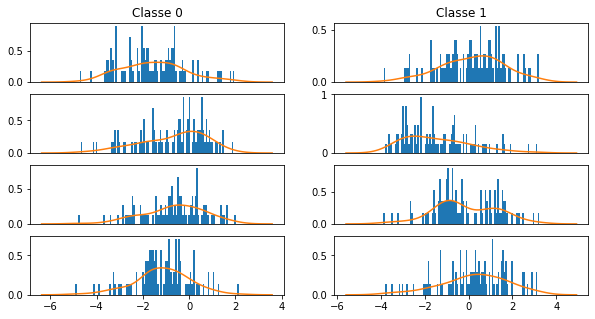

In [7]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 5), nrows=4, ncols=2)

for c in range(2):
    mask = y == c
    for i in range(X.shape[1]):
        X_filt = X[mask, i]
        ax[i][c].hist(X_filt, bins=100, density=True)
        sns.kdeplot(X_filt, ax=ax[i][c])
        
        if i < 3:
            ax[i][c].set_xticks([])
ax[0][0].title.set_text('Classe 0')
ax[0][1].title.set_text('Classe 1')

### Conclusão: 

Podemos perceber que a utilização de distribuições gaussianas pode não ser a melhor ideia sempre

Vamos criar um KDENaiveBayes e observar como ele se sai. O sklearn implementa a estimação de densidade de kernel no submodulo `neighbors`. Podemos importar essa ferramenta com:

```python
from sklearn.neighbors import KernelDensity
```

Acessaremos a documentação da classe `KernelDensity`:

In [8]:
from sklearn.neighbors import KernelDensity

help(KernelDensity)

Help on class KernelDensity in module sklearn.neighbors._kde:

class KernelDensity(sklearn.base.BaseEstimator)
 |  KernelDensity(*, bandwidth=1.0, algorithm='auto', kernel='gaussian', metric='euclidean', atol=0, rtol=0, breadth_first=True, leaf_size=40, metric_params=None)
 |  
 |  Kernel Density Estimation.
 |  
 |  Read more in the :ref:`User Guide <kernel_density>`.
 |  
 |  Parameters
 |  ----------
 |  bandwidth : float
 |      The bandwidth of the kernel.
 |  
 |  algorithm : str
 |      The tree algorithm to use.  Valid options are
 |      ['kd_tree'|'ball_tree'|'auto'].  Default is 'auto'.
 |  
 |  kernel : str
 |      The kernel to use.  Valid kernels are
 |      ['gaussian'|'tophat'|'epanechnikov'|'exponential'|'linear'|'cosine']
 |      Default is 'gaussian'.
 |  
 |  metric : str
 |      The distance metric to use.  Note that not all metrics are
 |      valid with all algorithms.  Refer to the documentation of
 |      :class:`BallTree` and :class:`KDTree` for a description 

Temos vários parâmetros que podem ser ajustados. Entre eles:

- Função kernel a ser utilizada (e.g., gaussiana)
- O algoritmo para calculo de vizinhança (podemos utilizar algoritmos aproximados, como a KDTree -- utilizada no k-NN)
- Podemos variar a métrica de distância
- Assim por diante

Aqui nos focaremos em apenas dois parâmetros:

- **bandwidth** $\rightarrow$ a largura de banda das múltiplas funções kernel a serem utilizadas. Esse hiperparâmetro será "visível" em nossa implementação. Deixaremos o valor `0.5` como padrão (por quê? Não faço a mínima ideia, me deu vontade agora :D -- um "chute" nada informado, digamos assim)
- **kernel** $\rightarrow$ a função kernel a ser utilizada. Deixaremos a `'gaussian'` como padrão.

Para mais informações sobre a classe de `KernelEstimation`, visitar a [documentação](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html) e esse [ótimo material introdutório](https://scikit-learn.org/stable/modules/density.html#kernel-density) do próprio sklearn.

Sem mais delongas, vamos criar nosso:

### KDENaiveBayes

In [9]:
# Faz nossa classe "custom-made" compatível com sklearn
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KernelDensity


class KDENaiveBayes(BaseEstimator, ClassifierMixin):
    """Our custom-made Naive Bayes implementation with KDE
    
    Parameters
    ----------
        bandwidth : float, optional (default: 0.5)
            The kernel bandwidth width
        kernel : str, optional (default: 'gaussian')
            The kernel name, passed to KernelDensity

    Notes
    -----
        It relies on sklearn.neighbors.KernelDensity to estimate the data density.
        This implementation must be used with numerical data, just like sklearn.naive_bayes.GaussianNB.
        This implementation was inspired on the one available in _[1].
        
    References
    ----------
    .. [1] https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html

    """
    def __init__(self, bandwidth=0.5, kernel='gaussian'):
        # Salvamos nossos hiperparâmetros
        self.bandwidth = bandwidth
        self.kernel = kernel
        
    def fit(self, X, y):
        # Seleciona as classes do problema
        self.classes = np.sort(np.unique(y))
        
        # Nossa probabilidade a priori de cada classe (aplicaremos log para evitar o multiplicatório)
        self.logpriors = {}
        # A estimativa de densidade para cada classe
        self.likelihood = {}
        for c in self.classes:
            # Filtra os dados de cada classe
            class_mask = y == c
            self.logpriors[c] = np.log(len(y[class_mask]) / len(y))
            self.likelihood[c] = KernelDensity(bandwidth=self.bandwidth, kernel=self.kernel)
            # Estimação das densidades
            self.likelihood[c].fit(X[class_mask])
            
        return self
            
        
    def predict_proba(self, X):
        # Numero de amostras x numero de classes
        proba = np.zeros((len(X), len(self.classes)))
        
        for c in self.classes:
            # O KDE nos dá o loglikelihood com a função score. Sabemos que:
            # log(a * b) = log(a) + log(b)
            # Nossos priors (probabilidade a priori) das classes foram transformados com log
            # Logo, basta somarmos os elementos e aplicar um função exp: a = exp(log(a))
            proba[:, c] = np.exp(self.likelihood[c].score_samples(X) + self.logpriors[c])
        
        
        # Por fim, aplicamos a função softmax para obter as probabilidades
        exp_proba = np.exp(proba)
        proba = exp_proba / np.sum(exp_proba, axis=1)[:, None]

        return proba
        
    def predict(self, X):
        return self.classes[np.argmax(self.predict_proba(X), axis=1)]

### Vamos ver como nos saímos:

In [10]:
score_print_10fold(X, y, classificador=KDENaiveBayes, bandwidth=0.5)

Acuracias: [0.85, 0.9, 0.9, 0.85, 0.9, 0.9, 0.9, 0.7, 1.0, 0.9]
Media: 0.8800 | Desvio padrão: 0.0714


Lembram do GaussianNaiveBayes?

In [11]:
score_print_10fold(X, y, classificador=GaussianNaiveBayes)

Acuracias: [0.8, 0.85, 0.85, 0.95, 0.8, 0.8, 0.75, 0.8, 0.85, 0.7]
Media: 0.8150 | Desvio padrão: 0.0634


Nos demos bem!!!

E se mudássemos o valor da banda?

In [12]:
score_print_10fold(X, y, classificador=KDENaiveBayes, bandwidth=0.2)

Acuracias: [0.9, 0.95, 0.9, 0.95, 0.85, 0.95, 0.9, 0.75, 1.0, 0.95]
Media: 0.9100 | Desvio padrão: 0.0663


E o kernel? (Nem tudo são flores)

In [13]:
score_print_10fold(X, y, classificador=KDENaiveBayes, bandwidth=0.2, kernel='tophat')

Acuracias: [0.55, 0.3, 0.4, 0.45, 0.55, 0.6, 0.7, 0.5, 0.35, 0.55]
Media: 0.4950 | Desvio padrão: 0.1150


#### Mais conclusões:

A utilização de KDE com o Naive Bayes torna as coisas mais interessantes!

- Com a escolha adequada do `kernel` e da `bandwidth` temos o potencial de obter melhores resultados do que o GaussianNB
- Existe um custo adicional de processamento envolvido! Quanto mais atributos de entrada, mais custoso é o calculo do KDE
    * Poderiamos também ter criado um KDE por atributo de entrada, assim como criamos uma Gaussiana por entrada para o GaussianNaiveBayes
    
Divirtam-se com essa implementação! Infelizmente o sklearn não nos provê uma versão do KDENaiveBayes :/